<a href="https://colab.research.google.com/github/EDMMaster/FraudDetection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Package Installs
!kaggle datasets download -d kartik2112/fraud-detection

Dataset URL: https://www.kaggle.com/datasets/kartik2112/fraud-detection
License(s): CC0-1.0
fraud-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [32]:
#Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
!unzip /content/fraud-detection.zip

Archive:  /content/fraud-detection.zip
replace fraudTest.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [34]:
!ls /content/

fraud-detection.zip  fraudTest.csv  fraudTrain.csv  sample_data


In [35]:
fraud_test_df = pd.read_csv('/content/fraudTest.csv')
fraud_train_df = pd.read_csv('/content/fraudTrain.csv')

In [36]:
fraud_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [37]:
# Set Panda to display all columns
pd.set_option("display.max_columns", None)

In [38]:
fraud_test_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


# Terry

In this analysis, we are exploring the hypothesis that if the geographic distance between the retailer’s location (represented by merch_lat and merch_long) and the cardholder’s address (represented by lat and long) exceeds 200 miles, it could be an indicator of fraudulent activity. To test this theory, we will calculate the distance between these two points using the Haversine formula. We will then use this distance as a feature in a supervised classification model to predict whether a transaction is fraudulent. The model chosen for this task is a Random Forest classifier due to its ability to handle complex patterns in large datasets. Finally, we will evaluate the model’s performance and visualize key results, such as the distribution of distances in fraudulent vs. non-fraudulent transactions and the confusion matrix, to assess the model's accuracy and fraud detection ability.

In [39]:
# Check for missing data
print("Missing values in fraudTrain.csv:")
print(fraud_train_df.isnull().sum())

print("\nMissing values in fraudTest.csv:")
print(fraud_test_df.isnull().sum())

Missing values in fraudTrain.csv:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

Missing values in fraudTest.csv:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
s

In [40]:
# Function to calculate Haversine distance in miles
def calc_haversine_distance(lat1, long1, lat2, long2):
    lat1, long1, lat2, long2 = map(np.radians, [lat1, long1, lat2, long2])
    dlat = lat2 - lat1
    dlong = long2 - long1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 3958.8  # Radius of Earth in miles
    return c * r

# Apply this function to both training and testing data
fraud_train_df['distance'] = calc_haversine_distance(fraud_test_df['lat'], fraud_train_df['long'], fraud_train_df['merch_lat'], fraud_train_df['merch_long'])
fraud_test_df['distance'] = calc_haversine_distance(fraud_test_df['lat'], fraud_test_df['long'], fraud_test_df['merch_lat'], fraud_test_df['merch_long'])

# Create a flag for distance > 200 miles
fraud_train_df['distance_flag'] = fraud_train_df['distance'] > 200
fraud_test_df['distance_flag'] = fraud_test_df['distance'] > 200

In [41]:
# Pre-processing




In [42]:
# Define features and target
features = ['amt', 'distance_flag'] + [col for col in fraud_train_df.columns if 'category_' in col or 'gender_' in col]

X_train = fraud_train_df[features]
y_train = fraud_train_df['is_fraud']

X_test = fraud_test_df[features]
y_test = fraud_test_df['is_fraud']

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [44]:
# Initialize and train the Random Forest classifier
rf = RandomForestClassifier(random_state=42, n_estimators=10,verbose=3,n_jobs=-1)
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 10building tree 2 of 10

building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.1s finished


RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42, verbose=3)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.7s finished


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.30      0.25      0.27      2145

    accuracy                           0.99    555719
   macro avg       0.65      0.62      0.64    555719
weighted avg       0.99      0.99      0.99    555719



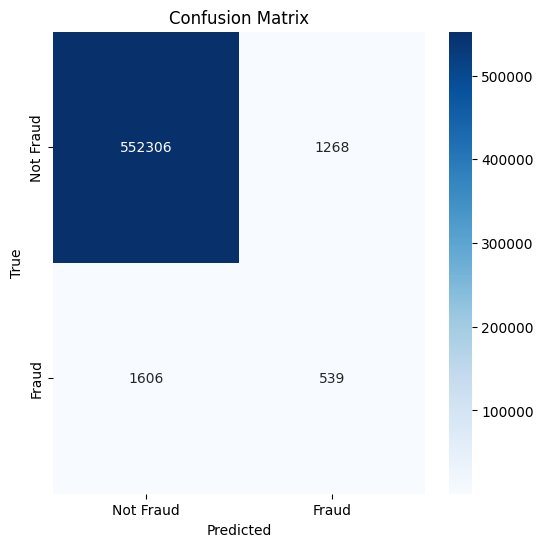

In [45]:
# Make predictions on the test set
y_pred = rf.predict(X_test)

# Generate classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

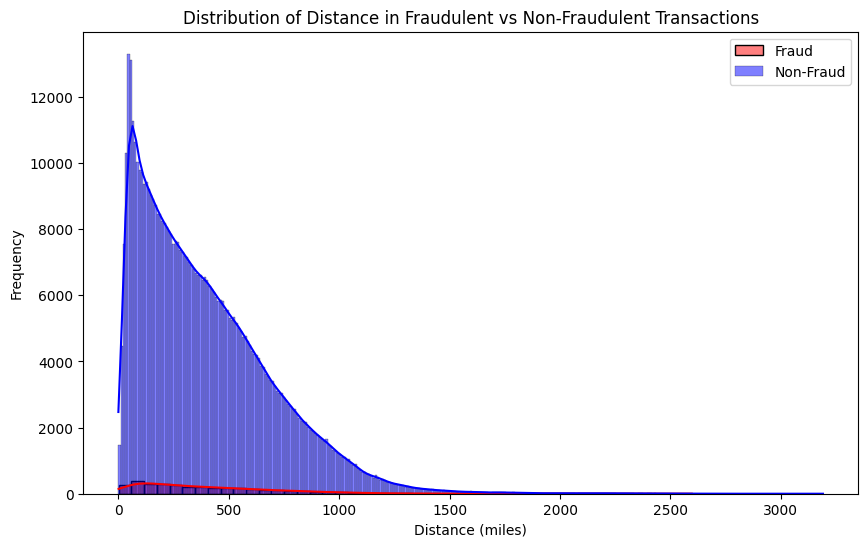

In [46]:
# Visualize distance distribution
plt.figure(figsize=(10,6))
sns.histplot(fraud_train_df[fraud_train_df['is_fraud'] == 1]['distance'], color='red', label='Fraud', kde=True)
sns.histplot(fraud_train_df[fraud_train_df['is_fraud'] == 0]['distance'], color='blue', label='Non-Fraud', kde=True)
plt.title('Distribution of Distance in Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Distance (miles)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Ivanna

In [47]:
# Convert 'trans_date_trans_time' to datetime
fraud_train_df['trans_date_trans_time'] = pd.to_datetime(fraud_train_df['trans_date_trans_time'])

# Extracting year, month, day, hour, and day of the week as new features
fraud_train_df['transaction_year'] = fraud_train_df['trans_date_trans_time'].dt.year
fraud_train_df['transaction_month'] = fraud_train_df['trans_date_trans_time'].dt.month
fraud_train_df['transaction_day'] = fraud_train_df['trans_date_trans_time'].dt.day
fraud_train_df['transaction_hour'] = fraud_train_df['trans_date_trans_time'].dt.hour
fraud_train_df['transaction_dayofweek'] = fraud_train_df['trans_date_trans_time'].dt.dayofweek

In [48]:
from sklearn.preprocessing import LabelEncoder

# Encoding categorical features
label_encoder = LabelEncoder()
fraud_train_df['category_encoded'] = label_encoder.fit_transform(fraud_train_df['category'])
fraud_train_df['gender_encoded'] = label_encoder.fit_transform(fraud_train_df['gender'])
fraud_train_df['job_encoded'] = label_encoder.fit_transform(fraud_train_df['job'])
# Display the dataset to verify the new date-related columns
print("\nDisplaying the dataset after extracting date features:")
display(fraud_train_df[['trans_date_trans_time', 'transaction_year', 'transaction_month',
                        'transaction_day', 'transaction_hour', 'transaction_dayofweek']].head())


Displaying the dataset after extracting date features:


,trans_date_trans_time,transaction_year,transaction_month,transaction_day,transaction_hour,transaction_dayofweek
0,2019-01-01 00:00:18,2019,1,1,0,1
1,2019-01-01 00:00:44,2019,1,1,0,1
2,2019-01-01 00:00:51,2019,1,1,0,1
3,2019-01-01 00:01:16,2019,1,1,0,1
4,2019-01-01 00:03:06,2019,1,1,0,1


In [49]:
from sklearn.preprocessing import StandardScaler

# Selecting numerical features to scale
numerical_features = ['amt', 'lat', 'long', 'merch_lat', 'merch_long', 'city_pop']

# Scaling numerical features
scaler = StandardScaler()
fraud_train_df[numerical_features] = scaler.fit_transform(fraud_train_df[numerical_features])
# Display the dataset to verify the encoded columns
print("\nDisplaying the dataset with encoded categorical variables:")
display(fraud_train_df[['category', 'category_encoded', 'gender', 'gender_encoded', 'job', 'job_encoded']].head())


Displaying the dataset with encoded categorical variables:


,category,category_encoded,gender,gender_encoded,job,job_encoded
0,misc_net,8,F,0,"Psychologist, counselling",370
1,grocery_pos,4,F,0,Special educational needs teacher,428
2,entertainment,0,M,1,Nature conservation officer,307
3,gas_transport,2,M,1,Patent attorney,328
4,misc_pos,9,M,1,Dance movement psychotherapist,116


In [50]:
from sklearn.model_selection import train_test_split

# Define features and target
X = fraud_train_df.drop('is_fraud', axis=1)  # Features
y = fraud_train_df['is_fraud']  # Target

# Split into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# Display the scaled features to ensure they have been standardized
print("\nDisplaying the dataset after scaling numerical features:")
display(fraud_train_df[numerical_features].head())


Displaying the dataset after scaling numerical features:


,amt,lat,long,merch_lat,merch_long,city_pop
0,-0.407826,-0.484420,0.657620,-0.494354,0.593864,-0.282589
1,0.230039,2.039120,-2.033870,2.078699,-2.030341,-0.293670
2,0.934149,0.717754,-1.601537,0.902849,-1.592323,-0.280406
3,-0.158132,1.515617,-1.590766,1.662886,-1.621848,-0.287742
4,-0.177094,-0.023035,0.782279,0.026941,0.841909,-0.293835


In [68]:
# Displaying the first few rows to verify the new columns
print("\nDisplaying the dataset after extracting date features:")
display(fraud_train_df[['trans_date_trans_time', 'transaction_year', 'transaction_month',
                        'transaction_day', 'transaction_hour', 'transaction_dayofweek']].head())


Displaying the dataset after extracting date features:


,trans_date_trans_time,transaction_year,transaction_month,transaction_day,transaction_hour,transaction_dayofweek
0,2019-01-01 00:00:18,2019,1,1,0,1
1,2019-01-01 00:00:44,2019,1,1,0,1
2,2019-01-01 00:00:51,2019,1,1,0,1
3,2019-01-01 00:01:16,2019,1,1,0,1
4,2019-01-01 00:03:06,2019,1,1,0,1


In [52]:
from sklearn.preprocessing import LabelEncoder

# Encoding categorical variables
label_encoder = LabelEncoder()
fraud_train_df['category_encoded'] = label_encoder.fit_transform(fraud_train_df['category'])
fraud_train_df['gender_encoded'] = label_encoder.fit_transform(fraud_train_df['gender'])
fraud_train_df['job_encoded'] = label_encoder.fit_transform(fraud_train_df['job'])

# Displaying the first few rows to verify the encoded columns
print("\nDisplaying the dataset with encoded categorical variables:")
display(fraud_train_df[['category', 'category_encoded', 'gender', 'gender_encoded', 'job', 'job_encoded']].head())



Displaying the dataset with encoded categorical variables:


,category,category_encoded,gender,gender_encoded,job,job_encoded
0,misc_net,8,F,0,"Psychologist, counselling",370
1,grocery_pos,4,F,0,Special educational needs teacher,428
2,entertainment,0,M,1,Nature conservation officer,307
3,gas_transport,2,M,1,Patent attorney,328
4,misc_pos,9,M,1,Dance movement psychotherapist,116


Scaling Numerical Features (Step 5):
Use StandardScaler to standardize features such as amt, lat, long, etc.

In [53]:
from sklearn.preprocessing import StandardScaler

# Selecting numerical features to scale
numerical_features = ['amt', 'lat', 'long', 'merch_lat', 'merch_long', 'city_pop']

# Scaling numerical features
scaler = StandardScaler()
fraud_train_df[numerical_features] = scaler.fit_transform(fraud_train_df[numerical_features])

# Displaying the first few rows to verify the scaled features
print("\nDisplaying the dataset after scaling numerical features:")
display(fraud_train_df[numerical_features].head())


Displaying the dataset after scaling numerical features:


,amt,lat,long,merch_lat,merch_long,city_pop
0,-0.407826,-0.484420,0.657620,-0.494354,0.593864,-0.282589
1,0.230039,2.039120,-2.033870,2.078699,-2.030341,-0.293670
2,0.934149,0.717754,-1.601537,0.902849,-1.592323,-0.280406
3,-0.158132,1.515617,-1.590766,1.662886,-1.621848,-0.287742
4,-0.177094,-0.023035,0.782279,0.026941,0.841909,-0.293835


In [54]:
# Display all column names to check their correctness
print(fraud_train_df.columns.tolist())

['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'distance', 'distance_flag', 'transaction_year', 'transaction_month', 'transaction_day', 'transaction_hour', 'transaction_dayofweek', 'category_encoded', 'gender_encoded', 'job_encoded']


In [55]:
# Updated columns_to_drop based on the current column names
columns_to_drop = ['street']  # 'street' is the only unnecessary column from the current list

# Dropping the columns
fraud_train_df = fraud_train_df.drop(columns=columns_to_drop, axis=1)

# Display the dataset to verify that unnecessary columns have been dropped
print("\nDisplaying the dataset after dropping unnecessary columns:")
display(fraud_train_df.head())


Displaying the dataset after dropping unnecessary columns:


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance,distance_flag,transaction_year,transaction_month,transaction_day,transaction_hour,transaction_dayofweek,category_encoded,gender_encoded,job_encoded
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,-0.407826,Jennifer,Banks,F,Moravian Falls,NC,28654,-0.484420,0.657620,-0.282589,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,-0.494354,0.593864,0,149.661320,False,2019,1,1,0,1,8,0,370
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,0.230039,Stephanie,Gill,F,Orient,WA,99160,2.039120,-2.033870,-0.293670,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,2.078699,-2.030341,0,610.678713,True,2019,1,1,0,1,4,0,428
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,0.934149,Edward,Sanchez,M,Malad City,ID,83252,0.717754,-1.601537,-0.280406,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,0.902849,-1.592323,0,171.290814,False,2019,1,1,0,1,0,1,307
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,-0.158132,Jeremy,White,M,Boulder,MT,59632,1.515617,-1.590766,-0.287742,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,1.662886,-1.621848,0,1276.024903,True,2019,1,1,0,1,2,1,328
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,-0.177094,Tyler,Garcia,M,Doe Hill,VA,24433,-0.023035,0.782279,-0.293835,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,0.026941,0.841909,0,387.784860,True,2019,1,1,0,1,9,1,116


In [56]:
# Display the remaining columns
print("\nRemaining columns after dropping:")
print(fraud_train_df.columns.tolist())


Remaining columns after dropping:
['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'distance', 'distance_flag', 'transaction_year', 'transaction_month', 'transaction_day', 'transaction_hour', 'transaction_dayofweek', 'category_encoded', 'gender_encoded', 'job_encoded']


In [57]:
from sklearn.model_selection import train_test_split

# Define features and target
X = fraud_train_df.drop('is_fraud', axis=1)  # Features
y = fraud_train_df['is_fraud']  # Target

# Split into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Displaying the shape of the training and testing sets
print("\nShape of training features:", X_train.shape)
print("Shape of training target:", y_train.shape)
print("Shape of test features:", X_test.shape)
print("Shape of test target:", y_test.shape)



Shape of training features: (907672, 31)
Shape of training target: (907672,)
Shape of test features: (389003, 31)
Shape of test target: (389003,)


In [58]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
# Define features (X) and target variable (y)
X = fraud_train_df.drop('is_fraud', axis=1)  # All columns except 'is_fraud'
y = fraud_train_df['is_fraud']  # Target column

# Split into training and test sets (already done previously but ensuring it's set up correctly)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [64]:
columns_to_drop = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
                   'first', 'last', 'gender', 'city', 'state', 'job', 'dob', 'trans_num']

X_train = X_train.drop(columns=columns_to_drop, axis=1)
X_test = X_test.drop(columns=columns_to_drop, axis=1)

# Display the remaining columns to verify
print("\nRemaining columns after dropping unnecessary ones:")
print(X_train.columns.tolist())



Remaining columns after dropping unnecessary ones:
['amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'distance', 'distance_flag', 'transaction_year', 'transaction_month', 'transaction_day', 'transaction_hour', 'transaction_dayofweek', 'category_encoded', 'gender_encoded', 'job_encoded']


In [65]:
# Verify that all columns are now numeric
print("\nData types of columns in X_train after dropping:")
print(X_train.dtypes)


Data types of columns in X_train after dropping:
amt                      float64
zip                        int64
lat                      float64
long                     float64
city_pop                 float64
unix_time                  int64
merch_lat                float64
merch_long               float64
distance                 float64
distance_flag               bool
transaction_year           int32
transaction_month          int32
transaction_day            int32
transaction_hour           int32
transaction_dayofweek      int32
category_encoded           int64
gender_encoded             int64
job_encoded                int64
dtype: object


In [67]:
# Initialize and train the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=50,verbose=3,n_jobs=-1, random_state=42)
rf_classifier.fit(X_train, y_train)
print("Model training completed successfully!")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.8min


building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
Model training completed successfully!


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.4min finished
